# Assignment 4

**Submission deadline: last lab session before or on Wednesday, 22.11.17**

**Points: 11 + 4 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

# Starter code: network for Irises in Pytorch


In the following cells a feedforward neural network has been implemented with the aid of PyTorch and its autograd mechanism. Please study the code - many network implementations follow a similar pattern.

The provided network trains to nearly 100% accuracy on Iris using Batch Gradient Descent.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable


class Layer(object):
    
    def train_mode(self):
        """Put layer into training mode.
        """
        pass
    
    def eval_mode(self):
        """Put layer into evalation mode.
        """
        pass
    
    @property
    def parameters(self):
        return []
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out):
        self.W = Variable(torch.FloatTensor(num_in, num_out),
                          requires_grad=True)
        self.W.name = 'W'
        self.b = Variable(torch.FloatTensor(1, num_out),
                          requires_grad=True)
        self.b.name = 'b'
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, x):
        return x.mm(self.W) + self.b

    
class TanhLayer(Layer):
    def forward(self, x):
        return F.tanh(x)

    
class  ReLULayer(Layer):
    def forward(self, x):
        return F.relu(x)


class SoftMaxLayer(Layer):
    def forward(self, x):
        return F.softmax(x)

In [3]:
class FeedforwardNet(object):
    def __init__(self, layers):
        self.layers = layers

    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params

    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP.data = newP.data
    
    def train_mode(self):
        for layer in self.layers:
            layer.train_mode()
    
    def eval_mode(self):
        for layer in self.layers:
            layer.eval_mode()    
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def loss(self, outputs, targets):
        return torch.mean(-torch.log(torch.gather(
            outputs, 1, targets.unsqueeze(1))))

In [4]:
from sklearn import datasets
import torchvision


iris = datasets.load_iris()
IrisX = iris.data.astype(np.float32)
IrisX = (IrisX - IrisX.mean(axis=0, keepdims=True)) / IrisX.std(axis=0, keepdims=True)
IrisY = iris.target

def GD(model, x, y, alpha=1e-4, max_iters=1000000, tolerance=1e-6):
    """Simple batch gradient descent"""
    try:
        old_loss = np.inf
        x = Variable(torch.from_numpy(x), requires_grad=False)
        y = Variable(torch.from_numpy(y.astype(np.int64)), requires_grad=False)
        model.train_mode()
        for i in xrange(max_iters):
            outputs = model.forward(x)
            loss = model.loss(outputs, y)

            loss.backward()
            for p in model.parameters:
                p.data -= p.grad.data * alpha
                # Zero gradients for the next iteration
                p.grad.data.zero_()

            loss = loss.data[0]
            if old_loss < loss:
                print "Iter: %d, loss increased!" % (i,)
            if (old_loss - loss) < tolerance:
                print "Tolerance level reached. Exiting."
                break
            if i % 1000 == 0:
                _, predictions = outputs.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / outputs.size(0)
                print "Iteration {0: >6} | loss {1: >5.2f} | err rate  {2: >5.2f}%" \
                      .format(i, loss, err_rate)
            old_loss = loss
    except KeyboardInterrupt:
        pass

In [5]:
model = FeedforwardNet(
    [AffineLayer(4, 10),
     TanhLayer(),
     AffineLayer(10, 3),
     SoftMaxLayer(),
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        # p.data.normal_(0, 0.05)
        p.data.uniform_(-0.1, 0.1)
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# Train
GD(model, IrisX, IrisY, alpha=1e-1, tolerance=1e-7)

Iteration      0 | loss  1.11 | err rate  94.00%
Iteration   1000 | loss  0.06 | err rate   2.00%
Iteration   2000 | loss  0.05 | err rate   2.00%
Iteration   3000 | loss  0.04 | err rate   1.33%
Iteration   4000 | loss  0.04 | err rate   1.33%
Iteration   5000 | loss  0.04 | err rate   1.33%
Iteration   6000 | loss  0.04 | err rate   1.33%
Iteration   7000 | loss  0.04 | err rate   1.33%
Iteration   8000 | loss  0.04 | err rate   1.33%
Iteration   9000 | loss  0.04 | err rate   1.33%
Iteration  10000 | loss  0.04 | err rate   1.33%
Iteration  11000 | loss  0.04 | err rate   1.33%
Iteration  12000 | loss  0.04 | err rate   1.33%
Iteration  13000 | loss  0.04 | err rate   1.33%
Iteration  14000 | loss  0.04 | err rate   1.33%
Iteration  15000 | loss  0.04 | err rate   1.33%
Iteration  16000 | loss  0.04 | err rate   1.33%
Iteration  17000 | loss  0.04 | err rate   1.33%
Iteration  18000 | loss  0.03 | err rate   1.33%
Iteration  19000 | loss  0.03 | err rate   1.33%
Iteration  20000 | l

# Starter code for MNIST and SGD scaffolding

In [5]:
import torch
import torchvision
import os


batch_size = 128
data_path = os.environ.get('PYTORCH_DATA_PATH', '../data')

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train.train_data = _train.train_data[:50000]
_train.train_labels = _train.train_labels[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.train_data = _valid.train_data[50000:]
_valid.train_labels = _valid.train_labels[50000:]

mnist_loaders = {
    'train': torch.utils.data.DataLoader(
        _train, batch_size=batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(
        _test, batch_size=batch_size, shuffle=False)}

In [20]:
def compute_error_rate(model, data_loader, cuda=False):
    model.eval_mode()
    num_errs = 0.0
    num_examples = 0
    for x, y in data_loader:
        if cuda:
            x = x.cuda()
            y = y.cuda()
        x = Variable(x.view(x.size(0), -1), volatile=True)
        y = Variable(y, volatile=True)
        outputs = model.forward(x)
        _, predictions = outputs.data.max(dim=1)
        num_errs += (predictions != y.data).sum()
        num_examples += x.size(0)
    return 100.0 * num_errs / num_examples

def SGD(model, data_loaders, alpha=1e-4, lambda_=0.0, c=1.0, epsilon=0.0, num_epochs=1, 
        patience_expansion=1.5, log_every=100, cuda=False):
    if cuda:
        for p in model.parameters:
            p.data = p.data.cuda()
    #
    # TODO: Initialize momentum variables
    # Hint: You need one velocity matrix for each parameter
    velocities = []
    for p in model.parameters:
        if cuda:
            velocities.append(torch.zeros(p.size()).cuda())
        else:
            velocities.append(torch.zeros(p.size()))
        
    alpha0 = alpha # added
    
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': []}
    print('Training the model!')
    print('Interrupt at any time to evaluate the best validation model so far.')
    try:
        while epoch < num_epochs:
            model.train_mode()
            epoch += 1
            for x, y in data_loaders['train']:
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                iter_ += 1
                x = Variable(x.view(x.size(0), -1), requires_grad=False)
                y = Variable(y, requires_grad=False)
                
                out = model.forward(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.data.max(dim=1)
                err_rate = 100.0 * (predictions != y.data).sum() / out.size(0)

                history['train_losses'].append(loss.data[0])
                history['train_errs'].append(err_rate)

                for p, v in zip(model.parameters, velocities):
                    if p.name == 'W':
                        # weight decay
                        p.grad.data += lambda_ * p.data                      
                        
                    # Update learning rate
#                     alpha = alpha0 * c ** iter_
                    if iter_ > 10000:
                        alpha = alpha0 / 2.0
                    
                    # Velocity update in momentum
                    v = epsilon * v + alpha * p.grad.data

                    # Set a more sensible learning rule here,
                    # using your learning rate schedule and momentum
                    
                    # old one
                    # p.data -= alpha * p.grad.data
                    
                    p.data -= v
                    
                    # Zero gradients for the next iteration
                    p.grad.data.zero_()

                if iter_ % log_every == 0:
                    print "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%" \
                          .format(iter_, loss.data[0], err_rate)
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], cuda)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.clone().cpu() for p in model.parameters]
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate, num_epochs)
            print '{0}\n{1}\n{0}'.format('-' * len(m), m)

    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print "\nLoading best params on validation set (epoch %d)\n" %(best_epoch)
        model.parameters = best_params
    plot_history(history)

def plot_history(history):
    figsize(16, 4)
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    legend()
        
    subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    ylim(0,20)
    legend()

# Problem 1: Stochastic Gradient Descent [3p]
Implement the following additions to the SGD code provided above:
  1. **[1p]** momentum
  2. **[1p]** learning rate schedule
  3. **[1p]** weight decay, in which we additionally minimize for each weight matrix (but typically not the bias) the sum of its elements squared. One way to implement it is to use function `model.parameters` and select all parameters whose names are "`W`" and not "`b`".

# Problem 2: Tuning the Network for MNIST [4p]

Tune the following network to reach **validation error rate below 1.9%**.
This should result in a **test error rate below 2%**. To
tune the network you will need to:
1. Choose the number of layers (more than 1, less than 5);
2. Choose the number of neurons in each layer (more than 100,
    less than 5000);
3. Pick proper weight initialization;
4. Pick proper learning rate schedule (need to decay over time,
    good range to check on MNIST is about 1e-2 ... 1e-1 at the beginning and
    half of that after 10000 batches);
5. Pick a momentum constant (probably a constant one will be OK).


Training the model!
Interrupt at any time to evaluate the best validation model so far.
Minibatch    100  | loss  0.35 | err rate 10.94%
Minibatch    200  | loss  0.12 | err rate  3.91%
Minibatch    300  | loss  0.12 | err rate  3.91%
----------------------------------------------------------
After epoch  1 | valid err rate:  3.34% | doing   2 epochs
----------------------------------------------------------
Minibatch    400  | loss  0.08 | err rate  2.34%
Minibatch    500  | loss  0.08 | err rate  2.34%
Minibatch    600  | loss  0.05 | err rate  0.78%
Minibatch    700  | loss  0.10 | err rate  3.91%
----------------------------------------------------------
After epoch  2 | valid err rate:  2.90% | doing   4 epochs
----------------------------------------------------------
Minibatch    800  | loss  0.03 | err rate  0.78%
Minibatch    900  | loss  0.01 | err rate  0.00%
Minibatch   1000  | loss  0.03 | err rate  0.78%
Minibatch   1100  | loss  0.06 | err rate  2.34%
-------------------

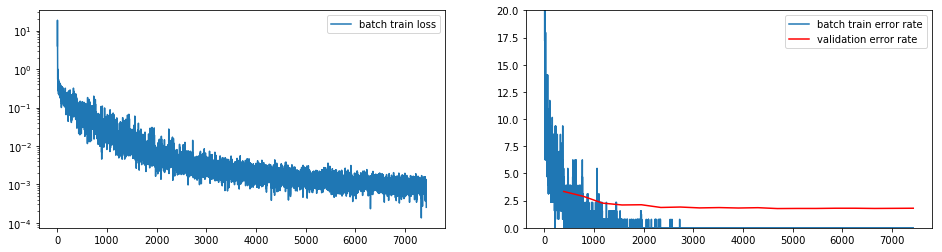

In [24]:
#
# TODO: Pick a network architecture here.
#       The one below is just softmax regression.
#

# TanhLayer    
# ReLULayer
# SoftMaxLayer

model = FeedforwardNet(
    [
     AffineLayer(784, 3000),
     TanhLayer(),
     AffineLayer(3000, 1000),
     ReLULayer(),      
     AffineLayer(1000, 10),
     SoftMaxLayer()
    ])

# Initialize parameters
for p in model.parameters:
    if p.name == 'W':
        p.data.normal_(0, 0.05)
        # p.data.uniform_(-0.1, 0.1)
    elif p.name == 'b':
        p.data.zero_()
    else:
        raise ValueError('Unknown parameter name "%s"' % p.name)

# On lab computers you can set cuda=True !
SGD(model, mnist_loaders, alpha=1e-1, lambda_=0.0, c=1.0, epsilon=0.9, cuda=True)

print "Test error rate: %.2f%%" % compute_error_rate(model, mnist_loaders['test'])

# Problem 3: Dropout [2p]

Implement a **dropout** layer and try to train a
network getting below 1.5% test error rates with dropout. The best
results with dropout are below 1%!

Remember to turn off dropout during testing, using `model.train_mode()` and `model.eval_mode()`!

Hint: Use [torch.nn.functional.dropout](http://pytorch.org/docs/master/nn.html#torch.nn.functional.dropout).

Details: http://arxiv.org/pdf/1207.0580.pdf.

# Problem 4: Data Augmentation [1p]

Apply data augmentation methods (e.g. rotations, noise, crops) when training networks on MNIST, to significantly reduce test error rate for your network. You can use functions from the [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html) module.

# Problem 5: Batch Normalization [1p]

*Covariate shift* is a phenomenon associated with training deep models. Simply put, weight changes in early layers cause major changes in distribution of inputs to later layers, making it difficult to train later layers.

[Batch Normalization](https://arxiv.org/abs/1502.03167) addresses this problem by normalizing distributions of inputs to layers within mini-batches. It typically allows to train networks faster and/or with higher learning rates, lessens the importance
of initialization and might eliminate the need for Dropout.

Implement Batch Normalization and compare with regular training of MNIST models.

Remember to use the batch statistics during model training and to use an average of training batch statistics during model evaluation. For details please consult the paper.

# Problem 6: Norm Constraints [1p bonus]

Implement norm constraints, i.e. instead of weight decay, that tries to set 
all weights to small values, apply a limit on the total
norm of connections incoming to a neuron. In our case, this
corresponds to clipping the norm of *rows* of weight
matrices. An easy way of implementing it is to make a gradient
step, then look at the norm of rows and scale down those that are
over the threshold (this technique is called "projected gradient descent").

Please consult the Dropout paper (http://arxiv.org/pdf/1207.0580.pdf) for details.

# Problem 6: Polyak Averaging [1p bonus]

Implement Polyak averaging. For each parameter $\theta$
keep a separate, exponentially decayed average of the past values
$$
\bar{\theta}_n = \alpha_p\bar{\theta}_{n-1} + (1-\alpha_p)\theta_n.
$$
Use that average when evaluating the model on the test set.
Validate the approach by training a model on the MNIST dataset.

# Problem 7: Convolutional Network [2p bonus]

Use convolutional and max-pooling layers (`torch.nn.functional.conv2d`, `torch.nn.functional.max_pool2d`) and (without dropout) get a test error rate below 1.5%.